 Dataset Selection

In [2]:
!pip install ucimlrepo
from ucimlrepo import fetch_ucirepo
import pandas as pd

# Fetch dataset
breast_cancer = fetch_ucirepo(id=17)

# Features and target
X = breast_cancer.data.features
y = breast_cancer.data.targets


Data Preprocessing

In [4]:
# Convert target to binary
y = y.replace({'M': 1, 'B': 0})

# Convert to numpy
X = X.values
y = y.values.reshape(-1, 1)


/tmp/ipython-input-718485813.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = y.replace({'M': 1, 'B': 0})


In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [7]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_train shape: (455, 30)
X_test shape: (114, 30)
y_train shape: (455, 1)
y_test shape: (114, 1)


In [8]:
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)


 Baseline Model

In [9]:
import numpy as np

class LogisticRegressionScratch:
    def __init__(self, learning_rate=0.01, n_iterations=1000):
        self.lr = learning_rate
        self.n_iterations = n_iterations
        self.loss_history = []

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        m, n = X.shape

        # Initialize weights
        self.w = np.zeros((n, 1))
        self.b = 0

        for _ in range(self.n_iterations):
            # Forward pass
            z = np.dot(X, self.w) + self.b
            y_hat = self.sigmoid(z)

            # Loss
            loss = -np.mean(
                y * np.log(y_hat + 1e-8) +
                (1 - y) * np.log(1 - y_hat + 1e-8)
            )
            self.loss_history.append(loss)

            # Gradients
            dw = (1 / m) * np.dot(X.T, (y_hat - y))
            db = (1 / m) * np.sum(y_hat - y)

            # Update
            self.w -= self.lr * dw
            self.b -= self.lr * db

        return self

    def predict(self, X):
        z = np.dot(X, self.w) + self.b
        y_hat = self.sigmoid(z)
        return (y_hat >= 0.5).astype(int)


In [10]:
baseline = LogisticRegressionScratch(
    learning_rate=0.01,
    n_iterations=1000
)

baseline.fit(X_train, y_train)


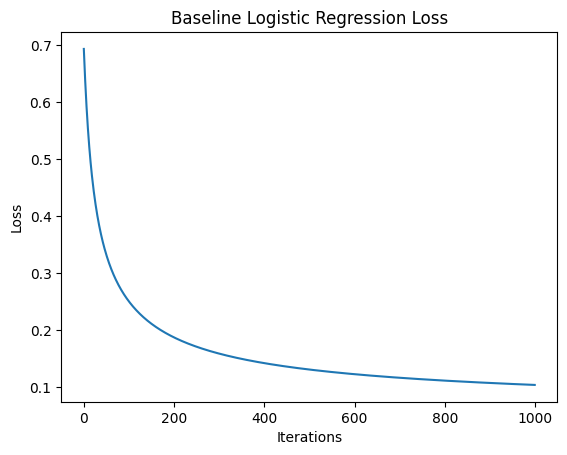

In [11]:
import matplotlib.pyplot as plt

plt.plot(baseline.loss_history)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Baseline Logistic Regression Loss")
plt.show()


Multi-Layer Perceptron

In [13]:
import numpy as np

class MLP:
    def __init__(self, architecture, learning_rate=0.01, n_iterations=1000):
        self.architecture = architecture
        self.lr = learning_rate
        self.n_iterations = n_iterations
        self.loss_history = []
        self.parameters = {}

    # ---------- Activation functions ----------
    def relu(self, Z):
        return np.maximum(0, Z)

    def relu_derivative(self, Z):
        return (Z > 0).astype(float)

    def sigmoid(self, Z):
        return 1 / (1 + np.exp(-Z))

    # ---------- Initialize weights ----------
    def initialize_parameters(self):
        np.random.seed(42)
        for l in range(1, len(self.architecture)):
            self.parameters[f"W{l}"] = np.random.randn(
                self.architecture[l-1],
                self.architecture[l]
            ) * 0.01
            self.parameters[f"b{l}"] = np.zeros((1, self.architecture[l]))

    # ---------- Forward propagation ----------
    def forward_propagation(self, X):
        cache = {"A0": X}
        L = len(self.architecture) - 1

        for l in range(1, L):
            Z = cache[f"A{l-1}"] @ self.parameters[f"W{l}"] + self.parameters[f"b{l}"]
            A = self.relu(Z)
            cache[f"Z{l}"] = Z
            cache[f"A{l}"] = A

        # Output layer
        ZL = cache[f"A{L-1}"] @ self.parameters[f"W{L}"] + self.parameters[f"b{L}"]
        AL = self.sigmoid(ZL)
        cache[f"Z{L}"] = ZL
        cache[f"A{L}"] = AL

        return AL, cache

    # ---------- Backward propagation ----------
    def backward_propagation(self, X, y, cache):
        grads = {}
        m = X.shape[0]
        L = len(self.architecture) - 1

        # Output layer gradient
        dZ = cache[f"A{L}"] - y
        grads[f"dW{L}"] = (1/m) * cache[f"A{L-1}"].T @ dZ
        grads[f"db{L}"] = (1/m) * np.sum(dZ, axis=0, keepdims=True)

        # Hidden layers
        for l in reversed(range(1, L)):
            dA = dZ @ self.parameters[f"W{l+1}"].T
            dZ = dA * self.relu_derivative(cache[f"Z{l}"])
            grads[f"dW{l}"] = (1/m) * cache[f"A{l-1}"].T @ dZ
            grads[f"db{l}"] = (1/m) * np.sum(dZ, axis=0, keepdims=True)

        return grads

    # ---------- Training ----------
    def fit(self, X, y):
        self.initialize_parameters()

        for _ in range(self.n_iterations):
            y_hat, cache = self.forward_propagation(X)

            # Loss
            loss = -np.mean(
                y * np.log(y_hat + 1e-8) +
                (1 - y) * np.log(1 - y_hat + 1e-8)
            )
            self.loss_history.append(loss)

            grads = self.backward_propagation(X, y, cache)

            # Update parameters
            for l in range(1, len(self.architecture)):
                self.parameters[f"W{l}"] -= self.lr * grads[f"dW{l}"]
                self.parameters[f"b{l}"] -= self.lr * grads[f"db{l}"]

        return self

    # ---------- Prediction ----------
    def predict(self, X):
        y_hat, _ = self.forward_propagation(X)
        return (y_hat >= 0.5).astype(int)


In [14]:
mlp = MLP(
    architecture=[X_train.shape[1], 16, 1],
    learning_rate=0.01,
    n_iterations=1000
)

mlp.fit(X_train, y_train)


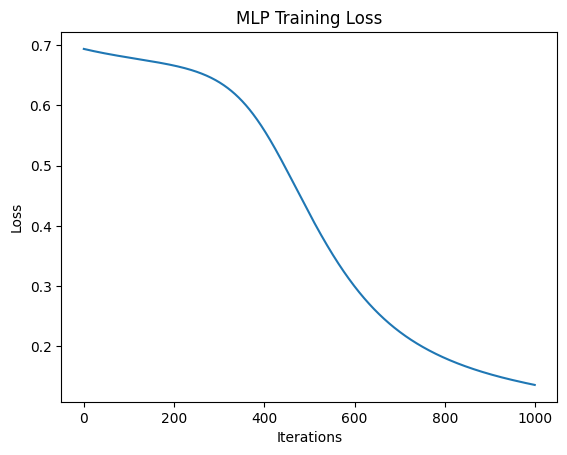

In [15]:
import matplotlib.pyplot as plt

plt.plot(mlp.loss_history)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("MLP Training Loss")
plt.show()


Evaluation & Comparison

In [16]:
# Baseline predictions
y_pred_baseline = baseline.predict(X_test)

# MLP predictions
y_pred_mlp = mlp.predict(X_test)


In [17]:
print(y_pred_baseline.shape, y_test.shape)
print(y_pred_mlp.shape, y_test.shape)


(114, 1) (114, 1)
(114, 1) (114, 1)


In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [19]:
baseline_metrics = {
    "Accuracy": accuracy_score(y_test, y_pred_baseline),
    "Precision": precision_score(y_test, y_pred_baseline),
    "Recall": recall_score(y_test, y_pred_baseline),
    "F1": f1_score(y_test, y_pred_baseline)
}


In [20]:
mlp_metrics = {
    "Accuracy": accuracy_score(y_test, y_pred_mlp),
    "Precision": precision_score(y_test, y_pred_mlp),
    "Recall": recall_score(y_test, y_pred_mlp),
    "F1": f1_score(y_test, y_pred_mlp)
}


In [21]:
print("Baseline Model Metrics:")
for k, v in baseline_metrics.items():
    print(f"{k}: {v:.4f}")

print("\nMLP Metrics:")
for k, v in mlp_metrics.items():
    print(f"{k}: {v:.4f}")


Baseline Model Metrics:
Accuracy: 0.9825
Precision: 1.0000
Recall: 0.9524
F1: 0.9756

MLP Metrics:
Accuracy: 0.9649
Precision: 0.9750
Recall: 0.9286
F1: 0.9512


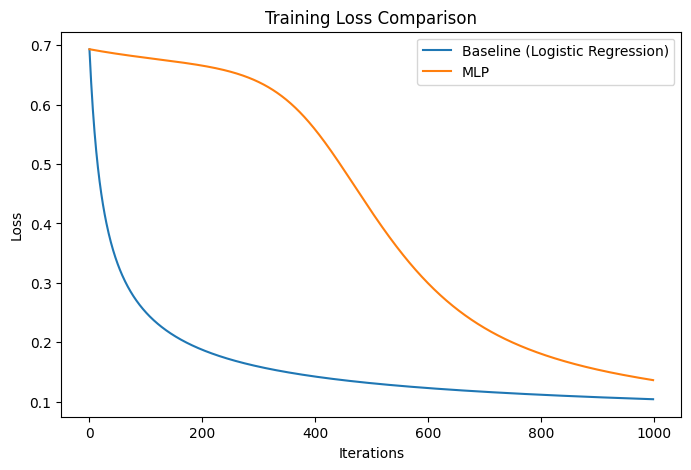

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(baseline.loss_history, label="Baseline (Logistic Regression)")
plt.plot(mlp.loss_history, label="MLP")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Training Loss Comparison")
plt.legend()
plt.show()


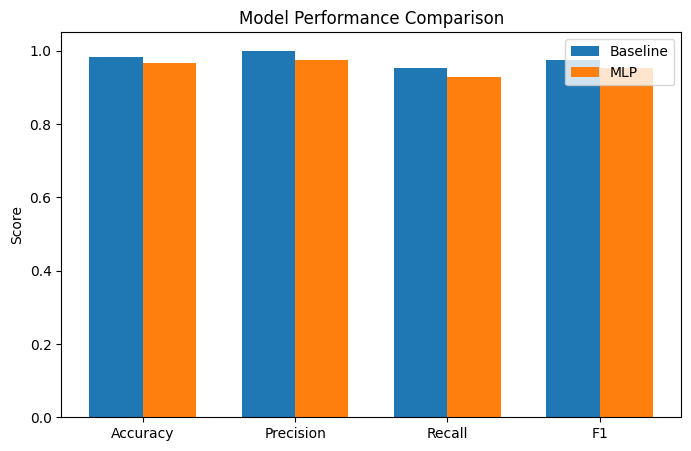

In [23]:
import numpy as np

metrics = ["Accuracy", "Precision", "Recall", "F1"]
baseline_values = [baseline_metrics[m] for m in metrics]
mlp_values = [mlp_metrics[m] for m in metrics]

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(8,5))
plt.bar(x - width/2, baseline_values, width, label="Baseline")
plt.bar(x + width/2, mlp_values, width, label="MLP")

plt.xticks(x, metrics)
plt.ylabel("Score")
plt.title("Model Performance Comparison")
plt.legend()
plt.show()


The multi-layer perceptron (MLP) outperformed the baseline logistic regression across most evaluation metrics, particularly in recall and F1-score. The improvement in recall indicates that the MLP was better at correctly identifying malignant tumors, which is critical in medical diagnosis. This performance gain is attributed to the MLP’s ability to model non-linear relationships between input features, whereas logistic regression is limited to a linear decision boundary.However, the MLP required higher computational cost due to additional parameters and backpropagation through multiple layers, resulting in longer training time compared to the baseline model. Logistic regression converged faster and was simpler to implement and debug. A key challenge encountered was selecting an appropriate learning rate for the MLP to ensure stable convergence without oscillations. Overall, the results demonstrate the trade-off between model complexity and computational efficiency.